In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import re
import collections 
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Data gathering and data cleaning

In [3]:
data = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/cmps242-spring18-hw5/train.csv')
test_data = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/cmps242-spring18-hw5/test.csv')

In [4]:
def string_from_list(A):
    if len(A)>0:
        B = (" ".join(A)).lower()
        return re.sub('[^a-zA-z0-9\s]','',B)
    else:
        return None 

In [5]:
data['handle']    = data['handle'].replace({'realDonaldTrump':1, 'HillaryClinton':0})

data['tweet']     = data['tweet'].apply((lambda x: re.sub(r"http\S+", '', x)))
data['tweet']     = data['tweet'].apply(lambda x: x.lower())
data['tweet']     = data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data['tweet']     = data['tweet'].apply((lambda x: re.sub(' +',' ',x)))

test_data['tweet']     = test_data['tweet'].apply((lambda x: re.sub(r"http\S+", '', x)))
test_data['tweet']     = test_data['tweet'].apply(lambda x: x.lower())
test_data['tweet']     = test_data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_data['tweet']     = test_data['tweet'].apply((lambda x: re.sub(' +',' ',x)))

all_tweets = pd.concat([data['tweet'], test_data['tweet']])

X       = data['tweet']
Y       = np.array(data['handle'].tolist())
X_test  = test_data['tweet']

In [6]:
X_train_bow_pd, X_val_bow_pd, Y_train_bow_pd, Y_val_bow_pd = train_test_split(X, Y,  test_size=0.1)

# Training bag of words models

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [8]:
count_vec         = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts    = count_vec.fit_transform(X_train_bow_pd)
X_train_tfidf     = tfidf_transformer.fit_transform(X_train_counts)

X_val_counts      = count_vec.transform(X_val_bow_pd)
X_val_tfidf       = tfidf_transformer.transform(X_val_counts)

In [9]:
hyperVec                  = [1e6,1e5,1e4,1e3,1e2,1e1,1e0,1e-1,1e-2]
loss_dic_bow              = {}

for C in hyperVec:
    lf_tmp = LogisticRegression(C=C)
    lf_tmp.fit(X_train_tfidf, Y_train_bow_pd)
    y_val_predicted_tmp = lf_tmp.predict(X_val_tfidf)
    loss_dic_bow[C] = log_loss(y_pred = y_val_predicted_tmp, y_true =  Y_val_bow_pd)

    
C_optimal = min(loss_dic_bow, key=loss_dic_bow.get)
#loss_dic_bow

In [10]:
X_counts           = count_vec.fit_transform(X)
X_tfidf            = tfidf_transformer.fit_transform(X_counts)

X_test_counts     = count_vec.transform(X_test)
X_test_tfidf      = tfidf_transformer.transform(X_test_counts)

lf = LogisticRegression(C = C_optimal)
lf.fit(X_tfidf, Y)
Y_bow_predicted_test = lf.predict(X_test_tfidf)

print(len(Y_bow_predicted_test))

1444


In [11]:
X_tfidf_np      = X_tfidf.toarray()
X_test_tfidf_np = X_test_tfidf.toarray()
X_train_tfidf, X_val_tfidf, Y_train_tfidf, Y_val_tfidf = train_test_split(X_tfidf_np,\
                                                                          Y, test_size = 0.1, random_state = 42)


bow_dim_size    = X_tfidf.shape[1]

print(X_test_tfidf_np.shape)
print(X_tfidf_np.shape)

(1444, 8871)
(5000, 8871)


In [12]:
X_all = []
for i in range(X.shape[0]):
    X_all.append(X[i].split())
    
for i in range(X_test.shape[0]):
    X_all.append(X_test[i].split())

In [13]:
tweets = all_tweets.tolist()
words  = " ".join(tweets)
words  = " ".join(words.split("\n")) 
words  = " ".join(words.split("\t"))
words  = " ".join(words.split("\xa0")).split()
whole_text = " ".join(words)

count          = collections.Counter(words)
count_clean    = [(item, count[item]) for item in count if count[item]>1]
vocab_size     = len(count_clean)
num_words      = vocab_size+2 

dic = {}

for i in range(vocab_size):
    dic[count_clean[i][0]] = (i+1, count_clean[i][1])

In [14]:
def string_to_token_list(A):
    B      = A.strip().split(" ")
    output = []
    for item in B:
        if item in dic:
            output.append(dic[item][0])
        else:
            output.append(vocab_size + 1)
    return output

In [15]:
X_tokens       = X.apply(lambda x: string_to_token_list(x))
X_test_tokens  = X_test.apply(lambda x: string_to_token_list(x)) 

num_tokens = [len(tokens) for tokens in X_tokens]
num_tokens = np.array(num_tokens)
max_tokens = int(np.max(num_tokens))

X_pad       = []
X_test_pad  = []

for item in X_tokens:
    n = len(item)
    X_pad.append([0]*(max_tokens-n) + item)

for item in X_test_tokens:
    n = len(item)
    X_test_pad.append([0]*(max_tokens-n) + item)
    
X_pad        = np.array(X_pad)
X_test_pad   = np.array(X_test_pad)
X_all_pad    = np.concatenate((X_pad , X_test_pad), axis=0)

In [16]:
X_train_pad, X_val_pad, Y_train_pad, Y_val_pad = train_test_split(X_pad, Y, test_size = 0.1, random_state = 42)

# Hyper parameter selection

In [39]:
lr                  = 1e-4
batch_size          = 64
embedding_size      = 256
lstm_out            = 64
lstm_dropout_prob   = 0.5
lstm_forget_bias    = 1.0

bow_hidden_layer_1_size  = 256
bow_hidden_layer_2_size  = 32

hidden_layer_1_size = 128
hidden_layer_2_size = 32

# Word embedding initialization 

In [40]:
from gensim.models import Word2Vec

model = Word2Vec(X_all, iter=10, min_count=2, size=embedding_size, workers=4)
#words = list(model.wv.vocab)
#print(words)
#print(model.wv.similar_by_word('makeamericagreatagain'))
#model.wv['trump'] 

In [41]:
embedding_matrix = np.zeros((1,embedding_size), np.float32)

for i in range(vocab_size):
    word             = count_clean[i][0]
    word_vec         = model.wv[word]
    embedding_matrix = np.vstack((embedding_matrix, word_vec))

embedding_matrix = np.vstack((embedding_matrix, 5* np.ones((1,embedding_size), np.float32)))

# Utility functions

In [42]:
def evaluate_test_data_set(filename, X_test_pad, X_test_tfidf_np, sess):
        test_size   = X_test_pad.shape[0]
        test_remain = batch_size - (test_size % batch_size) 
        X_test_pad      = np.concatenate((X_test_pad, np.zeros((test_remain, max_tokens), np.float32)), axis=0)
        X_test_tfidf_np = np.concatenate((X_test_tfidf_np, np.zeros((test_remain, bow_dim_size), np.float32)), axis=0)
        m = test_size // batch_size 
        pred_test_vals = np.empty((0, 2), np.float32)

        for i in range(m+1):
            input_test_batch      = X_test_pad[i * batch_size : (i+1) * batch_size, :]
            input_X_test_tfidf    = X_test_tfidf_np[i * batch_size : (i+1) * batch_size, :]
            test_preds_list  = sess.run([predictions], feed_dict = {X_bow : input_X_test_tfidf, 
                                                                    X     : input_test_batch})
            pred_test_batch  = np.asarray(test_preds_list).reshape(batch_size, 2)
            pred_test_vals   = np.concatenate((pred_test_vals, pred_test_batch), axis=0)
                 
            
        with open(filename,"w+") as outputfile:
            outputfile.write("id,realDonaldTrump,HillaryClinton\n")
            for j in range(test_size):
                hillary = pred_test_vals[j][1]
                donald  = pred_test_vals[j][0]
                outputfile.write(str(j)+","+str(donald)+","+str(hillary)+"\n")

In [43]:
def get_batch(X, Y, X_tfidf, size):
    rdm         = np.random.choice(X.shape[0], size , replace = False)
    y1          = Y[rdm].reshape((size,1))
    y2          = (y1+1)%2
    Y_out       = np.concatenate((y1, y2), axis=1)
    X_out       = X[rdm,:]
    X_tfidf_out = X_tfidf[rdm,:] 
    return X_tfidf_out, X_out, Y_out

#### Look at 
https://github.com/bernhard2202/twitter-sentiment-analysis/blob/master/model/lstm.py

For a similar implementation

# Computational graph

In [44]:
with tf.device("/cpu:0"):
    
    tf.reset_default_graph()
    tf.set_random_seed(0)

    X_bow = tf.placeholder(tf.float32, shape=[batch_size, bow_dim_size])
    X     = tf.placeholder(tf.int32, shape=[batch_size, max_tokens])
    Y     = tf.placeholder(tf.float32, shape=[batch_size,2])
        
    embeddings     = tf.Variable(embedding_matrix)    
    embed          = tf.nn.embedding_lookup(embeddings, X)
    embed          = tf.unstack(embed, max_tokens, 1)
    
    lstm_cell                 = tf.contrib.rnn.BasicLSTMCell(lstm_out, forget_bias = lstm_forget_bias)
    lstm_cell                 = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=lstm_dropout_prob)
    lstm_output , lstm_state  = tf.contrib.rnn.static_rnn(lstm_cell, inputs=embed , dtype=tf.float32)
    
    outputs                   = tf.stack(lstm_output)
    outputs                   = tf.gather(outputs, max_tokens-1, axis=0)
    outputs                   = tf.reshape(outputs, [batch_size, lstm_out])
    lstm_final_output         = tf.reshape(outputs, [batch_size , lstm_out])
    
    bow_hidden_layer_1_output = tf.layers.dense(X_bow, bow_hidden_layer_1_size)
    bow_hidden_layer_2_output = tf.layers.dense(bow_hidden_layer_1_output, bow_hidden_layer_2_size)
    
    bow_concat_lstm           = tf.concat( [lstm_final_output, X_bow], axis=1)
    
    hidden_layer_1_output     = tf.layers.dense(bow_concat_lstm, hidden_layer_1_size)
    hidden_layer_2_output     = tf.layers.dense(hidden_layer_1_output, hidden_layer_2_size)
    
    out_weight      = tf.Variable(tf.random_normal([hidden_layer_2_size, 2]))
    out_bias        = tf.Variable(tf.random_normal([2]))
    
    scores          = tf.nn.xw_plus_b(hidden_layer_2_output, out_weight,out_bias)
    predictions     = tf.nn.softmax(scores)
    
    losses          = tf.nn.softmax_cross_entropy_with_logits_v2(logits = scores,
                                                              labels = Y)
    loss            = tf.reduce_mean(losses)
    
    correct_pred    = tf.equal(tf.argmax(predictions, 1), tf.argmax(Y, 1))
    accuracy        = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    optimizer       = tf.train.AdamOptimizer(lr).minimize(loss)

# Running the computational graph

In [47]:
epochs           = 1000
display_epoch    = 100

loss_val_vec     = []
accur_val_vec    = []
loss_train_vec   = []
accur_train_vec  = []
epoch_vec = []

with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(epochs):
            batch_bow_vals, batch_inputs, batch_labels = get_batch(X_train_pad, 
                                                                   Y_train_pad, 
                                                                   X_train_tfidf,
                                                                   batch_size)
            loss_train, accur_train, _ = sess.run([loss, accuracy, optimizer],
                                                  feed_dict = {X_bow : batch_bow_vals,
                                                               X     : batch_inputs,
                                                               Y     : batch_labels})
            
            batch_bow_vals, batch_inputs, batch_labels = get_batch(X_val_pad, 
                                                                   Y_val_pad, 
                                                                   X_val_tfidf,
                                                                   batch_size)
            
            loss_val, accur_val = sess.run([loss, accuracy],
                                           feed_dict = {X_bow : batch_bow_vals,
                                                        X     : batch_inputs,
                                                        Y     : batch_labels})
                
            loss_train_vec.append(loss_train)
            accur_train_vec.append(accur_train)
            loss_val_vec.append(loss_val)
            accur_val_vec.append(accur_val)
            epoch_vec.append(epoch)
            
            if epoch % display_epoch == 0:
                print("Epoch " +str(epoch) + ", Batch loss = ", 
                      "%.3f, " % loss_train , "training accuray = ",  "%.3f, " % accur_train, "val loss = ",
                      "%.3f, " % loss_val , "val accuray = ",  "%.3f, " % accur_val)
        
        evaluate_test_data_set("/Users/mohsenkiskani/Downloads/submissions/submission_lstm_results.csv",
                               X_test_pad, X_test_tfidf_np, sess)

Epoch 0, Batch loss =  1.996,  training accuray =  0.453,  val loss =  1.394,  val accuray =  0.609, 
Epoch 100, Batch loss =  0.402,  training accuray =  0.844,  val loss =  0.390,  val accuray =  0.844, 
Epoch 200, Batch loss =  0.314,  training accuray =  0.891,  val loss =  0.302,  val accuray =  0.875, 
Epoch 300, Batch loss =  0.218,  training accuray =  0.922,  val loss =  0.278,  val accuray =  0.906, 
Epoch 400, Batch loss =  0.089,  training accuray =  0.969,  val loss =  0.194,  val accuray =  0.922, 
Epoch 500, Batch loss =  0.057,  training accuray =  0.984,  val loss =  0.337,  val accuray =  0.844, 
Epoch 600, Batch loss =  0.042,  training accuray =  1.000,  val loss =  0.218,  val accuray =  0.922, 
Epoch 700, Batch loss =  0.065,  training accuray =  0.969,  val loss =  0.154,  val accuray =  0.922, 
Epoch 800, Batch loss =  0.032,  training accuray =  0.984,  val loss =  0.158,  val accuray =  0.922, 
Epoch 900, Batch loss =  0.022,  training accuray =  1.000,  val l

# Plotting the results

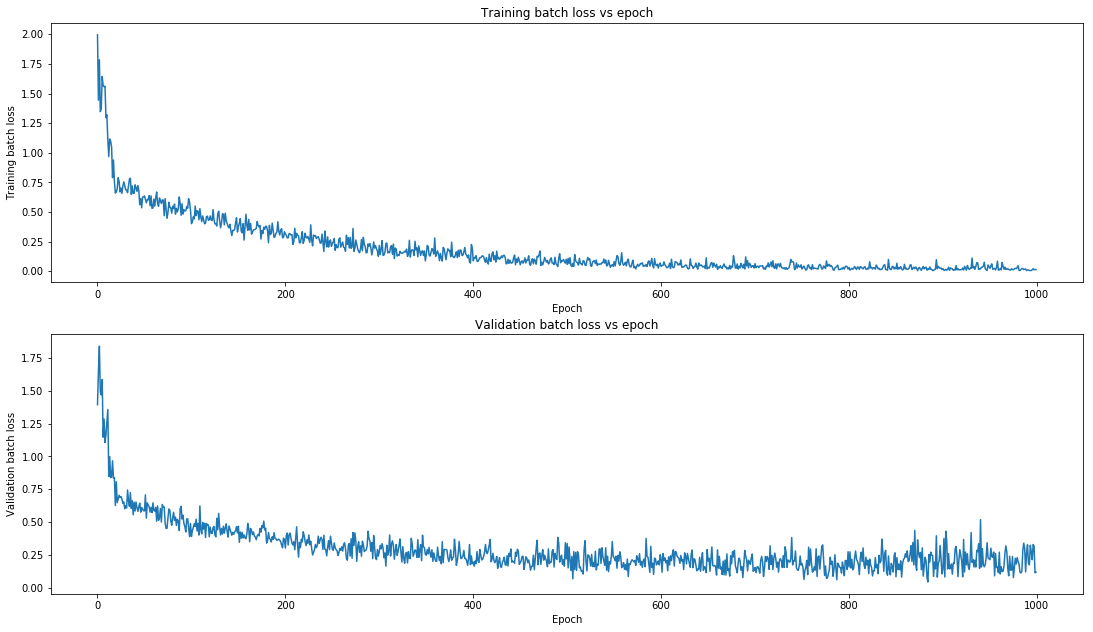

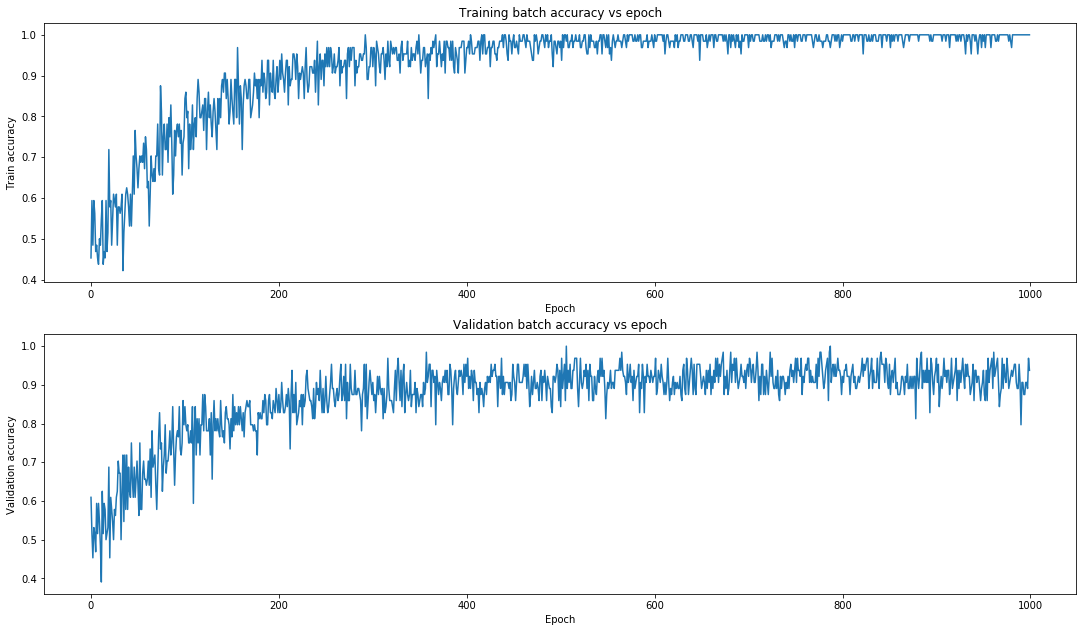

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, (ay1, ay2) = plt.subplots(2, 1)
ay1.plot(epoch_vec, loss_train_vec)
ay2.plot(epoch_vec, loss_val_vec)

fig2, (ay3, ay4) = plt.subplots(2, 1)
ay3.plot(epoch_vec, accur_train_vec)
ay4.plot(epoch_vec, accur_val_vec)

ay1.set_title('Training batch loss vs epoch')
ay1.set_xlabel('Epoch')
ay1.set_ylabel('Training batch loss')

ay2.set_title('Validation batch loss vs epoch')
ay2.set_xlabel('Epoch')
ay2.set_ylabel('Validation batch loss')

ay3.set_title('Training batch accuracy vs epoch')
ay3.set_xlabel('Epoch')
ay3.set_ylabel('Train accuracy')

ay4.set_title('Validation batch accuracy vs epoch')
ay4.set_xlabel('Epoch')
ay4.set_ylabel('Validation accuracy')

fig1.set_size_inches(18.5, 10.5)
fig1.savefig('loss.png', dpi=100)

fig2.set_size_inches(18.5, 10.5)
fig2.savefig('accuracy.png', dpi=100)
plt.show()